In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature

#import utils.contrastive_decoder_utils
from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

# Hyper-parameters

In [2]:
import os
FEATURE_DIM = 32 # fixed

# MODEL_PATH = './output/lerf-fruit_aisle/'
MODEL_PATH = './output/lund_1024' # 30000

FEATURE_GAUSSIAN_ITERATION = 10000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

# Data and Model Preparation


In [3]:
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(1, 32, bias=True),
    torch.nn.Sigmoid()
)

scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
scale_gate = scale_gate.cuda()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument('--target', default='scene', type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)

# If use language-driven segmentation, load clip feature and original masks
dataset.need_features = True

# To obtain mask scales
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ./output/lund_1024/cfg_args
Config file found: ./output/lund_1024/cfg_args
Loading trained model at iteration 30000, 10000
Allow Camera Principle Point Shift: False
Reading camera 1196/1196
✅ Loaded 1196 cameras for this GPU (start_idx=0, end_idx=None)
Loading Training Cameras
Loading Test Cameras


In [4]:
from sklearn.preprocessing import QuantileTransformer
# Borrowed from GARField, but modified
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()

    scales = scales.detach().cpu().numpy()
    print(scales.max(), '?')

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    
    def quantile_transformer_func(scales):
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func, quantile_transformer
    
all_scales = []
all_scales = []
for cam in scene.getTrainCameras():
    scale_path = os.path.join(dataset.source_path, 'mask_scales', cam.image_name + '.pt')
    scales = torch.load(scale_path)
    all_scales.append(scales)

all_scales = torch.cat(all_scales)

upper_bound_scale = all_scales.max().item()
# upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

# all_scales = []
# for cam in scene.getTrainCameras():
#     cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
#     all_scales.append(cam.mask_scales)
# all_scales = torch.cat(all_scales)

# quantile transformer
q_trans, q_trans_ = get_quantile_func(all_scales, 'uniform')




18.245272 ?


In [5]:
all_scales.max()

tensor(18.2453, grad_fn=<MaxBackward1>)

In [6]:
# For saving the normal q_trans, if the q_trans is uniform, we don't have to save it

# from joblib import dump, load
# dump(q_trans_, 'quantile_trans_test.jl')
# a = load('quantile_trans_test.jl')

In [7]:
upper_bound_scale

18.245271682739258

In [8]:
q_trans(torch.Tensor([70]))

tensor([1.])

# Begin Segmenting

In [9]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")
print(upper_bound_scale)

There are 1196 views in the dataset.
18.245271682739258


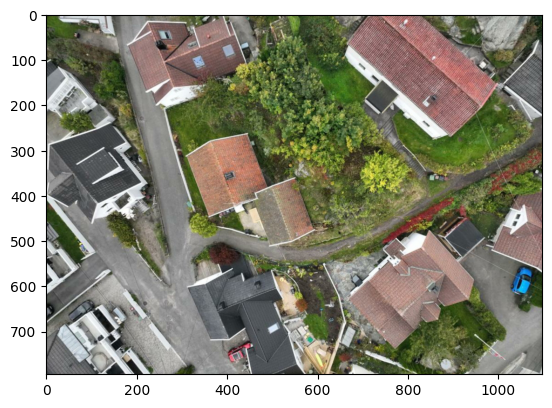

In [10]:
ref_img_camera_id = 17
mask_img_camera_id = 0

view = deepcopy(cameras[ref_img_camera_id])

view.feature_height, view.feature_width = view.image_height, view.image_width
img = view.original_image * 255
img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type = None)['render']
feature_h, feature_w = rendered_feature.shape[-2:]


plt.imshow(img)

# Point Prompt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14798294..0.100664616].


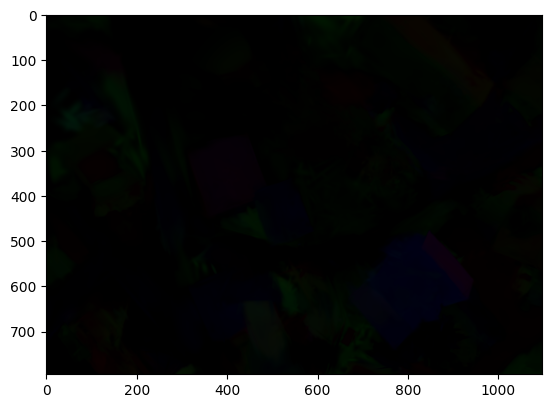

In [11]:
with torch.no_grad():
    # If the q_trans is normal
    # scale = 2.
    # scale = torch.full((1,), scale).cuda()
    # scale = q_trans(scale)

    # If the q_trans is uniform, the scale can be any value between 0 and 1
    # scale = torch.tensor([0]).cuda()
    # scale = torch.tensor([0.5]).cuda()
    scale = torch.tensor([1,]).cuda()

    gates = scale_gate(scale)

    feature_with_scale = rendered_feature
    feature_with_scale = feature_with_scale * gates.unsqueeze(-1).unsqueeze(-1)
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])

    plt.imshow(scale_conditioned_feature[:,:,:3].detach().cpu().numpy())

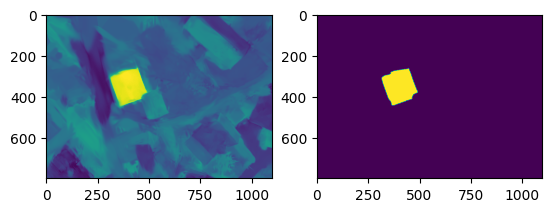

In [12]:
query_index = (300, 400)

query_index = (
    int(query_index[0] / view.image_height * view.feature_height),
    int(query_index[1] / view.image_width * view.feature_width),
               )

normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
query_feature = normed_features[query_index[0], query_index[1]]

similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)


plt.subplot(1,2,1)
plt.imshow(similarity.detach().cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(similarity.detach().cpu().numpy() > 0.75)

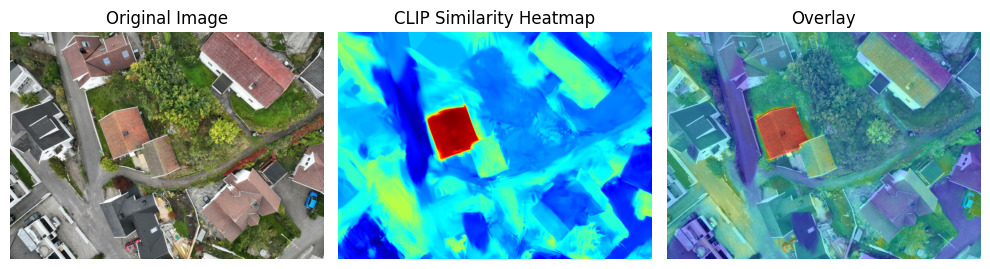

In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 1. Render the original image from view
img = view.original_image * 255
img = img.permute([1, 2, 0]).detach().cpu().numpy().astype(np.uint8)
img_resized = cv2.resize(img, (feature_w, feature_h))  # resize to match feature map

# 2. Compute similarity map (you already have this)
# similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)
sim_map = similarity.detach().cpu().numpy()
sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min())  # normalize to 0-1

# 3. Convert similarity map to heatmap
heatmap = cv2.applyColorMap((sim_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
# Make sure heatmap and image have same resolution
if img_resized.shape[:2] != heatmap.shape[:2]:
    heatmap = cv2.resize(heatmap, (img_resized.shape[1], img_resized.shape[0]))

# Make sure both are 3-channel
if len(img_resized.shape) == 2:
    img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

# Now blend
overlay = cv2.addWeighted(img_resized, 0.6, heatmap, 0.4, 0)

# 4. Blend heatmap with image
#overlay = cv2.addWeighted(img_resized, 0.6, heatmap, 0.4, 0)

# 5. Show the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_resized)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("CLIP Similarity Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")
plt.tight_layout()
plt.show()

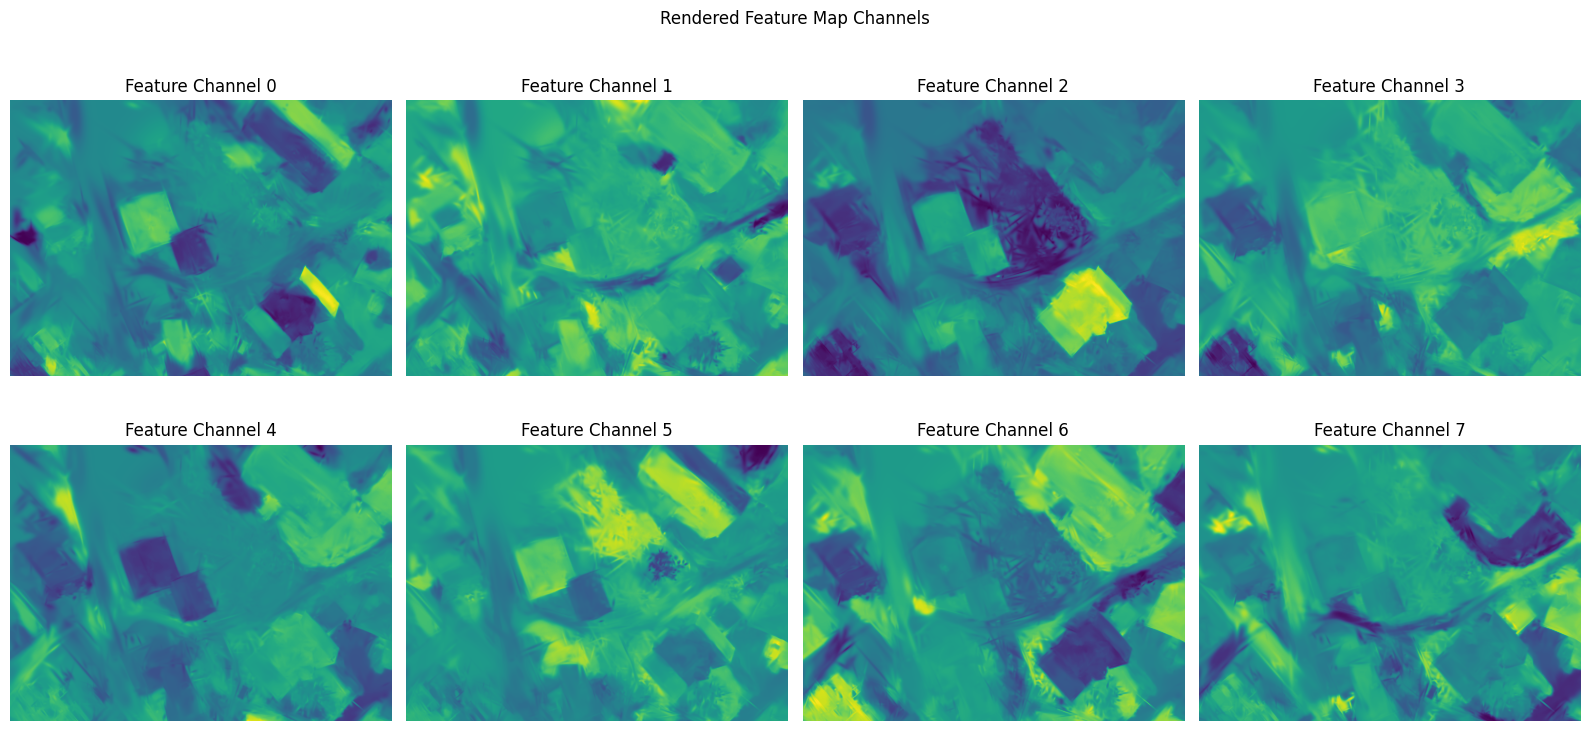

In [14]:
feature_map = rendered_feature.detach().cpu()  # (C, H, W)
C, H, W = feature_map.shape

# Show first 8 channels (you can change this)
plt.figure(figsize=(16, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(feature_map[i], cmap='viridis')
    plt.title(f"Feature Channel {i}")
    plt.axis('off')
plt.suptitle("Rendered Feature Map Channels")
plt.tight_layout()
plt.show()


In [15]:
# SHOW PCA in 2D

# # CHW -> PCA dimension reduction DHW (D=3)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)


# # t = pca.fit_transform(torch.nn.functional.normalize(rendered_feature, dim = 0).reshape(rendered_feature.shape[0], -1).permute([1,0]).cpu().detach().numpy())
# t = pca.fit_transform(normed_features.reshape(-1, normed_features.shape[-1]).cpu().detach().numpy())

# t = (t - t.min(axis=0)) / (t.max(axis=0)-t.min(axis=0))
# t = t.reshape(normed_features.shape[0], normed_features.shape[1], 3)
# plt.imshow(t)

# Cluster in 2D

In [16]:
#!pip install hdbscan

In [17]:
downsampled_features = torch.nn.functional.interpolate(scale_conditioned_feature.permute([2,0,1]).unsqueeze(0), (128, 128), mode = 'bilinear').squeeze()
cluster_normed_features = torch.nn.functional.normalize(downsampled_features, dim = 0, p = 2).permute([1,2,0])

In [18]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)
cluster_labels = clusterer.fit_predict(cluster_normed_features.reshape([-1, cluster_normed_features.shape[-1]]).detach().cpu().numpy())
labels = cluster_labels.reshape([cluster_normed_features.shape[0], cluster_normed_features.shape[1]])
print(np.unique(labels))

cluster_centers = torch.zeros(len(np.unique(labels))-1, cluster_normed_features.shape[-1])
for i in range(1, len(np.unique(labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(cluster_normed_features[labels == i-1].mean(dim = 0), dim = -1)

label_to_color = np.random.rand(200, 3)

/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151]


In [19]:

label_to_color = np.random.rand(200, 3)
segmentation_res = torch.einsum('nc,hwc->hwn', cluster_centers.cuda(), normed_features)

segmentation_res_idx = segmentation_res.argmax(dim = -1)
colored_labels = label_to_color[segmentation_res_idx.cpu().numpy().astype(np.int8)]

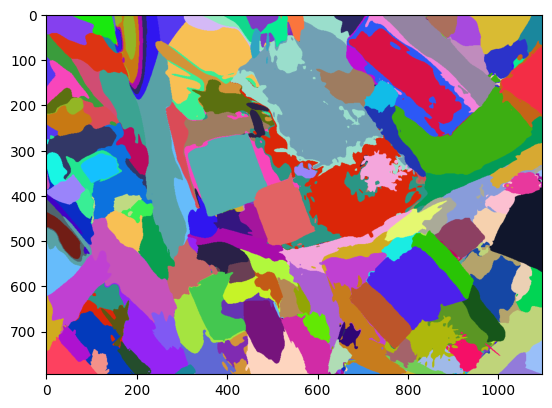

In [20]:
plt.imshow(colored_labels)

# Segmentation in 3D

After obtaining query features, we can use it to segment objects in 3D.

In [21]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = point_features * gates.unsqueeze(0)


In [85]:
normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

similarities = torch.einsum('C,NC->N', query_feature.cuda(), normed_scale_conditioned_point_features)
print(normed_scale_conditioned_point_features.device, query_feature.device, similarities.device)

similarities[similarities < 0.15] = 0

cuda:0 cuda:0 cuda:0


In [86]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
#rendered_similarities = render(cameras[0], scene_gaussians, pipeline.extract(args), background, override_color=similarities.unsqueeze(-1).repeat([1,3]))['render']
rendered_similarities = render(
    cameras[17], scene_gaussians, pipeline.extract(args), background
)['render']

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print("Type:", type(rendered_similarities))
print("Device:", rendered_similarities.device)
print("Shape:", rendered_similarities.shape)
print("Min:", rendered_similarities.min())
print("Max:", rendered_similarities.max())
print("Has NaN?", torch.isnan(rendered_similarities).any())
print("Has Inf?", torch.isinf(rendered_similarities).any())

plt.imshow(rendered_similarities.permute([1,2,0])[:,:,0].detach().cpu() > 0.75)

In [88]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(similarities > 0.3)

In [89]:
# save the segmentation
name = 'precomputed_mask'
import os
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(similarities > 0.3, f'./segmentation_res/{name}.pt')

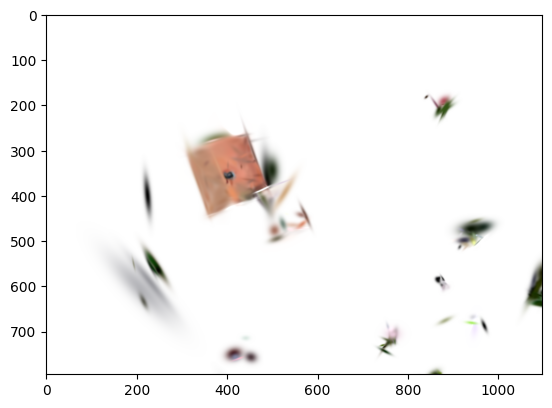

In [90]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[17], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())

In [28]:
scene_gaussians.roll_back()

# Cluster in 3D

In [29]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim = -1, p = 2) * gates.unsqueeze(0)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.98]

normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim = -1, keepdim = True)

print(len(sampled_point_features))

19916


In [30]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)

/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142]


In [31]:
seg_score = torch.einsum('nc,bc->bn', cluster_centers.cpu(), normed_point_features.cpu())

In [32]:
label_to_color = np.random.rand(1000, 3)
point_colors = label_to_color[seg_score.argmax(dim = -1).cpu().numpy()]
point_colors[seg_score.max(dim = -1)[0].detach().cpu().numpy() < 0.5] = (0,0,0)

In [33]:
try:
    scene_gaussians.roll_back()
except:
    pass

In [58]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


rendered_seg_map = render(cameras[17], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

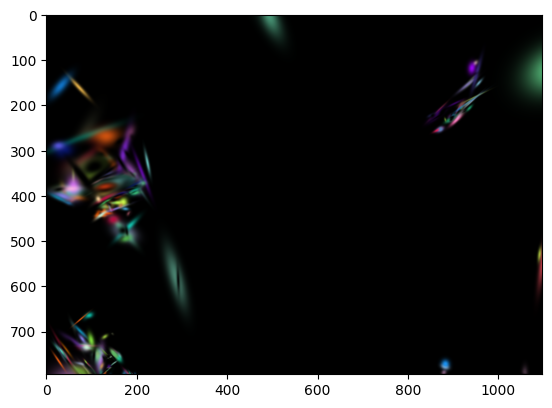

In [59]:
plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())

# Language-driven Segmentation

In [36]:
# sample some anchor points in 3D
anchor_point_features = feature_gaussians.get_point_features[torch.rand(feature_gaussians.get_point_features.shape[0]) > 0.99]
print(len(anchor_point_features))

10085


In [37]:
from copy import deepcopy

seg_features = []
clip_features = []
scales = []
mask_identifiers = []
camera_id_mask_id = []

# vote_weights = []

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

i=0
for view in scene.getTrainCameras():
    torch.cuda.empty_cache()
    clip_features.append(view.original_features)
    tmp_view = deepcopy(view)
    tmp_view.feature_height, tmp_view.feature_width = view.original_image.shape[-2:]

    rendered_feature = render_contrastive_feature(tmp_view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)['render']
    feature_h, feature_w = rendered_feature.shape[-2:]

    with torch.no_grad():
        # NOTE: 3D-OVS need 8x downsample since its images are in 4K resolution
        # rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 8, feature_w // 8), mode = 'bilinear').squeeze()
        # sam_masks = view.original_masks.cuda().unsqueeze(1)
        # sam_masks = torch.nn.functional.interpolate(sam_masks, (feature_h // 8, feature_w // 8), mode = 'bilinear')

        rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 4, feature_w // 4), mode = 'bilinear').squeeze()
        #sam_masks = view.original_masks.cuda().unsqueeze(1)
        sam_masks = torch.load(view.original_masks).cuda().unsqueeze(1)
        sam_masks = torch.nn.functional.interpolate(sam_masks.float(), (feature_h // 4, feature_w // 4), mode = 'bilinear')


        sam_masks = torch.conv2d(
            sam_masks.float().cpu(),
            torch.full((3, 3), 1.0).view(1, 1, 3, 3).cpu(),
            padding=1,
        )
        sam_masks = sam_masks >= 2
        sam_masks = sam_masks.cuda()


        # vote_weights is the number of pixels in the mask
        # vote_weights.append(sam_masks.sum(dim = -1).sum(dim = -1))

        # sam_masks = torch.nn.functional.interpolate(sam_masks.unsqueeze(1), (view.feature_height, view.feature_width), mode = 'bilinear')
        # sam_masks[sam_masks > 0.75] = 1
        # sam_masks[sam_masks != 1] = 0

        #mask_scales = view.mask_scales.cuda().unsqueeze(-1)
        mask_scales = torch.load(view.mask_scales).cuda().unsqueeze(-1)
        mask_scales = q_trans(mask_scales)

        scale_gates = scale_gate(mask_scales)
        
        # int_sampled_scales = ((1 - mask_scales.squeeze()) * 10).long()
        # scale_gates = fixed_scale_gate[int_sampled_scales].detach()

        # N_scale N_anchor C
        # scale_conditioned_anchor_point_features = torch.einsum('nc,mc->nmc',scale_gates, anchor_point_features)
        scale_conditioned_anchor_point_features = scale_gates.unsqueeze(1) * anchor_point_features.unsqueeze(0)
        scale_conditioned_anchor_point_features = torch.nn.functional.normalize(scale_conditioned_anchor_point_features, dim = -1, p = 2)

        # N_scale C H W
        scale_conditioned_feature = rendered_feature.unsqueeze(0) * scale_gates.unsqueeze(-1).unsqueeze(-1)
        scale_conditioned_feature = torch.nn.functional.normalize(scale_conditioned_feature, dim = 1, p = 2)

        # N_scale C
        mask_features = (sam_masks * scale_conditioned_feature).sum(dim = -1).sum(dim = -1) / (sam_masks.sum(dim = -1).sum(dim = -1) + 1e-9)
        mask_features = torch.nn.functional.normalize(mask_features, dim = -1, p = 2)

        mask_identifier = torch.einsum('nmc,nc->nm', scale_conditioned_anchor_point_features, mask_features) > 0.5
        
        mask_identifiers.append(mask_identifier.cpu())
        seg_features.append(mask_features)
        #scales.append(view.mask_scales.cuda().unsqueeze(-1))
        scales.append(torch.load(view.mask_scales).cuda().unsqueeze(-1))
        for j in range(len(mask_features)):
            camera_id_mask_id.append((i, j))
        i+=1
torch.cuda.empty_cache()

In [38]:
flattened_mask_features = torch.cat(seg_features, dim = 0)
#flattened_clip_features = torch.cat(clip_features, dim = 0)
clip_features = [torch.load(path).cuda() for path in clip_features]
flattened_clip_features = torch.cat(clip_features, dim=0)
flattened_clip_features = torch.nn.functional.normalize(flattened_clip_features.float(), dim = -1, p = 2)
flattened_scales = torch.cat(scales, dim = 0)
flattened_mask_identifiers = torch.cat(mask_identifiers, dim = 0).to(torch.float16).cuda()
flattened_mask_features.shape, flattened_clip_features.shape, flattened_scales.shape, flattened_mask_identifiers.shape, len(camera_id_mask_id)

(torch.Size([225658, 32]),
 torch.Size([225658, 512]),
 torch.Size([225658, 1]),
 torch.Size([225658, 10085]),
 225658)

In [39]:

'''with torch.no_grad():
    distance_map = 1 - (torch.einsum('mc,nc->mn', flattened_mask_identifiers, flattened_mask_identifiers) / (flattened_mask_identifiers.sum(dim = -1).unsqueeze(-1) + flattened_mask_identifiers.sum(dim = -1).unsqueeze(0) - torch.einsum('mc,nc->mn', flattened_mask_identifiers, flattened_mask_identifiers) + 1e-6))'''

"with torch.no_grad():\n    distance_map = 1 - (torch.einsum('mc,nc->mn', flattened_mask_identifiers, flattened_mask_identifiers) / (flattened_mask_identifiers.sum(dim = -1).unsqueeze(-1) + flattened_mask_identifiers.sum(dim = -1).unsqueeze(0) - torch.einsum('mc,nc->mn', flattened_mask_identifiers, flattened_mask_identifiers) + 1e-6))"

In [40]:
'''import os
import torch
from tqdm import tqdm

save_dir = "/home/niranjanar/masterThesis/SegAnyGAussians_final/distance_chunks"
os.makedirs(save_dir, exist_ok=True)

flattened_mask_identifiers = flattened_mask_identifiers.cpu().float()  # Ensure on CPU
num = flattened_mask_identifiers.shape[0]
chunk_size = 500  # Tune as needed

print("Saving distance chunks to disk (.pt)...")

for i, start in enumerate(tqdm(range(0, num, chunk_size))):
    end = min(start + chunk_size, num)

    A = torch.einsum('mc,nc->mn', flattened_mask_identifiers[start:end], flattened_mask_identifiers)
    row_sums = flattened_mask_identifiers[start:end].sum(dim=-1).unsqueeze(-1)
    col_sums = flattened_mask_identifiers.sum(dim=-1).unsqueeze(0)
    
    D = 1 - (A / (row_sums + col_sums - A + 1e-6))

    torch.save(D.cpu(), os.path.join(save_dir, f"chunk_{i:04d}.pt"))

    del D  # free memory'''


'import os\nimport torch\nfrom tqdm import tqdm\n\nsave_dir = "/home/niranjanar/masterThesis/SegAnyGAussians_final/distance_chunks"\nos.makedirs(save_dir, exist_ok=True)\n\nflattened_mask_identifiers = flattened_mask_identifiers.cpu().float()  # Ensure on CPU\nnum = flattened_mask_identifiers.shape[0]\nchunk_size = 500  # Tune as needed\n\nprint("Saving distance chunks to disk (.pt)...")\n\nfor i, start in enumerate(tqdm(range(0, num, chunk_size))):\n    end = min(start + chunk_size, num)\n\n    A = torch.einsum(\'mc,nc->mn\', flattened_mask_identifiers[start:end], flattened_mask_identifiers)\n    row_sums = flattened_mask_identifiers[start:end].sum(dim=-1).unsqueeze(-1)\n    col_sums = flattened_mask_identifiers.sum(dim=-1).unsqueeze(0)\n    \n    D = 1 - (A / (row_sums + col_sums - A + 1e-6))\n\n    torch.save(D.cpu(), os.path.join(save_dir, f"chunk_{i:04d}.pt"))\n\n    del D  # free memory'

In [41]:
'''import glob
import numpy as np
import torch

chunk_files = sorted(glob.glob(os.path.join(save_dir, "chunk_*.pt")))
full_shape = (len(chunk_files) * chunk_size, num)  # Adjust if last chunk is smaller

npy_path = "/home/niranjanar/full_distance_map.npy"
mmap_array = np.memmap(npy_path, dtype='float64', mode='w+', shape=full_shape)

for i, f in enumerate(chunk_files):
    chunk = torch.load(f).numpy().astype(np.float64)
    mmap_array[i * chunk_size: i * chunk_size + chunk.shape[0]] = chunk

del mmap_array  # Flush to disk
print("✅ Full distance map saved to:", npy_path)'''


'import glob\nimport numpy as np\nimport torch\n\nchunk_files = sorted(glob.glob(os.path.join(save_dir, "chunk_*.pt")))\nfull_shape = (len(chunk_files) * chunk_size, num)  # Adjust if last chunk is smaller\n\nnpy_path = "/home/niranjanar/full_distance_map.npy"\nmmap_array = np.memmap(npy_path, dtype=\'float64\', mode=\'w+\', shape=full_shape)\n\nfor i, f in enumerate(chunk_files):\n    chunk = torch.load(f).numpy().astype(np.float64)\n    mmap_array[i * chunk_size: i * chunk_size + chunk.shape[0]] = chunk\n\ndel mmap_array  # Flush to disk\nprint("✅ Full distance map saved to:", npy_path)'

In [42]:
'''import torch
import numpy as np
from hdbscan import HDBSCAN
import time

print("🔄 Loading distance map (memory-mapped)...")
start = time.time()

# Use memmap to avoid full RAM loading
distance_map = np.memmap("/home/niranjanar/full_distance_map.npy", dtype='float64', mode='r', shape=(num, num))

print(f"✅ Loaded distance map with shape {distance_map.shape} in {time.time() - start:.2f} seconds")

# Run HDBSCAN
print("🚀 Running HDBSCAN clustering...")
start = time.time()

clusterer = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.25, metric='precomputed')
cluster_labels_np = clusterer.fit_predict(distance_map)

print(f"✅ HDBSCAN completed in {time.time() - start:.2f} seconds")
print(f"📊 Unique cluster labels (excluding noise): {np.unique(cluster_labels_np[cluster_labels_np != -1])}")

# Convert to torch
cluster_labels = torch.from_numpy(cluster_labels_np).to(flattened_clip_features.device, dtype=torch.long)
'''

'import torch\nimport numpy as np\nfrom hdbscan import HDBSCAN\nimport time\n\nprint("🔄 Loading distance map (memory-mapped)...")\nstart = time.time()\n\n# Use memmap to avoid full RAM loading\ndistance_map = np.memmap("/home/niranjanar/full_distance_map.npy", dtype=\'float64\', mode=\'r\', shape=(num, num))\n\nprint(f"✅ Loaded distance map with shape {distance_map.shape} in {time.time() - start:.2f} seconds")\n\n# Run HDBSCAN\nprint("🚀 Running HDBSCAN clustering...")\nstart = time.time()\n\nclusterer = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.25, metric=\'precomputed\')\ncluster_labels_np = clusterer.fit_predict(distance_map)\n\nprint(f"✅ HDBSCAN completed in {time.time() - start:.2f} seconds")\nprint(f"📊 Unique cluster labels (excluding noise): {np.unique(cluster_labels_np[cluster_labels_np != -1])}")\n\n# Convert to torch\ncluster_labels = torch.from_numpy(cluster_labels_np).to(flattened_clip_features.device, dtype=torch.long)\n'

In [44]:
import umap
from hdbscan import HDBSCAN
import torch
import numpy as np

# Step 1: Move to CPU and convert to NumPy
features = flattened_mask_identifiers.cpu().to(torch.float32).numpy()  # shape: (N, D)

# Step 2: Dimensionality reduction using UMAP
print("🔄 Running UMAP...")
reducer = umap.UMAP(n_components=64, metric='cosine', random_state=42)
features_umap = reducer.fit_transform(features)  # shape: (N, 64)

# Step 3: Cluster with HDBSCAN
print("🔍 Clustering with HDBSCAN...")
clusterer = HDBSCAN(min_cluster_size=30, metric='euclidean')  # Now using reduced features
cluster_labels = clusterer.fit_predict(features_umap)

# Step 4: Convert to Torch
cluster_labels = torch.from_numpy(cluster_labels).to(device=flattened_clip_features.device)
print(f"✅ Found {len(torch.unique(cluster_labels[cluster_labels != -1]))} clusters (excluding noise)")


🔄 Running UMAP...


/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🔍 Clustering with HDBSCAN...


/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Found 1961 clusters (excluding noise)


In [45]:
# Construct vote graph

'''from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.25, metric='precomputed')
cluster_labels = clusterer.fit_predict(distance_map.detach().cpu().numpy().astype(np.float64))
cluster_labels = torch.from_numpy(cluster_labels).to(device = flattened_clip_features.device, dtype = torch.long)'''

"from hdbscan import HDBSCAN\n\nclusterer = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.25, metric='precomputed')\ncluster_labels = clusterer.fit_predict(distance_map.detach().cpu().numpy().astype(np.float64))\ncluster_labels = torch.from_numpy(cluster_labels).to(device = flattened_clip_features.device, dtype = torch.long)"

In [46]:
'''from hdbscan import HDBSCAN

print("Running HDBSCAN directly on flattened_mask_identifiers (vector input)...")
clusterer = HDBSCAN(min_cluster_size=30, metric='jaccard')  # 'jaccard' works for binary mask identifiers
cluster_labels = clusterer.fit_predict(flattened_mask_identifiers.cpu().numpy())
cluster_labels = torch.from_numpy(cluster_labels).to(device=flattened_clip_features.device, dtype=torch.long)

print(f"✅ Found {len(torch.unique(cluster_labels[cluster_labels != -1]))} clusters (excluding noise).")
'''

'from hdbscan import HDBSCAN\n\nprint("Running HDBSCAN directly on flattened_mask_identifiers (vector input)...")\nclusterer = HDBSCAN(min_cluster_size=30, metric=\'jaccard\')  # \'jaccard\' works for binary mask identifiers\ncluster_labels = clusterer.fit_predict(flattened_mask_identifiers.cpu().numpy())\ncluster_labels = torch.from_numpy(cluster_labels).to(device=flattened_clip_features.device, dtype=torch.long)\n\nprint(f"✅ Found {len(torch.unique(cluster_labels[cluster_labels != -1]))} clusters (excluding noise).")\n'

In [47]:
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template
from clip_utils.clip_utils import load_clip
clip_model = load_clip()
clip_model.eval()
1

Embedding dimension 512


1

In [48]:
# Convert input text prompts to scores for multi-view masks

scores = get_scores_with_template(clip_model, flattened_clip_features.cuda(), "house")
scores = scores.squeeze()

In [49]:
'''prompts = ["house", "building", "villa", "cabin", "roof","home","apartment","houses","all"]
all_scores = []

for prompt in prompts:
    scores = get_scores_with_template(clip_model, flattened_clip_features.cuda(), prompt)
    print(' prompt', prompt)
    print('score',scores)
    all_scores.append(scores.squeeze())  # (N,) for each class'''


'prompts = ["house", "building", "villa", "cabin", "roof","home","apartment","houses","all"]\nall_scores = []\n\nfor prompt in prompts:\n    scores = get_scores_with_template(clip_model, flattened_clip_features.cuda(), prompt)\n    print(\' prompt\', prompt)\n    print(\'score\',scores)\n    all_scores.append(scores.squeeze())  # (N,) for each class'

In [50]:
cluster_scores = torch.zeros(len(torch.unique(cluster_labels)), device=cluster_labels.device)
for cluster_idx in torch.unique(cluster_labels):
    cluster_scores[cluster_idx] = scores[cluster_labels == cluster_idx].mean()

In [51]:
def cluster_id_to_scales(cluster_labels, flattened_scales, cluster_idx, scores):
    max_score_mask_scale_id = scores[cluster_labels == cluster_idx].argmax()
    return flattened_scales[cluster_labels == cluster_idx][max_score_mask_scale_id].item(), max_score_mask_scale_id

cluster_labels.unique(), cluster_labels.unique()[cluster_scores.argmax()], cluster_scores.max()

(tensor([  -1,    0,    1,  ..., 1958, 1959, 1960], device='cuda:0'),
 tensor(1908, device='cuda:0'),
 tensor(0.6739, device='cuda:0'))

In [52]:
good_clusters = torch.where(cluster_scores > 0.45)[0]
good_cluster_scores = cluster_scores[good_clusters]
print('cluster_scores',cluster_scores)
print('good cluster_scores',good_cluster_scores)
if len(good_clusters) != 0:
    print(len(good_clusters))
    good_clusters = [cluster_labels.unique()[i] for i in good_clusters]
else:
    good_clusters = [cluster_labels.unique()[cluster_scores.argmax()]]

clip_query_features = []
corresponding_scales = []

for g in good_clusters:

    s, ind = cluster_id_to_scales(cluster_labels, flattened_scales, g, scores)
    clip_query_features.append(torch.nn.functional.normalize(flattened_mask_features[cluster_labels == g][ind], dim = -1, p = 2))

    corresponding_scales.append(s)

cluster_scores tensor([0.4505, 0.3830, 0.4154,  ..., 0.4372, 0.5855, 0.3967], device='cuda:0')
good cluster_scores tensor([0.4505, 0.5118, 0.4604, 0.4766, 0.4654, 0.4689, 0.4551, 0.4504, 0.4601,
        0.5411, 0.4858, 0.4524, 0.4574, 0.4592, 0.4524, 0.5013, 0.5320, 0.4556,
        0.4704, 0.4629, 0.5285, 0.6086, 0.5194, 0.4506, 0.4744, 0.4652, 0.4650,
        0.5256, 0.4845, 0.4510, 0.4847, 0.5058, 0.4997, 0.4728, 0.4871, 0.4537,
        0.4604, 0.4695, 0.4956, 0.4511, 0.4546, 0.4500, 0.5326, 0.4548, 0.4598,
        0.4720, 0.4502, 0.5346, 0.5096, 0.4754, 0.4582, 0.5477, 0.4869, 0.6434,
        0.5615, 0.5666, 0.5268, 0.5517, 0.6445, 0.4642, 0.4575, 0.5283, 0.4568,
        0.4732, 0.4514, 0.4634, 0.5906, 0.4573, 0.4833, 0.5972, 0.6434, 0.4806,
        0.4725, 0.4529, 0.4869, 0.4797, 0.4579, 0.4672, 0.5480, 0.4681, 0.5349,
        0.4914, 0.5302, 0.4503, 0.5023, 0.4879, 0.4525, 0.4790, 0.4684, 0.4508,
        0.4637, 0.5258, 0.5638, 0.5127, 0.5474, 0.4533, 0.4543, 0.4642, 0.5490,
     

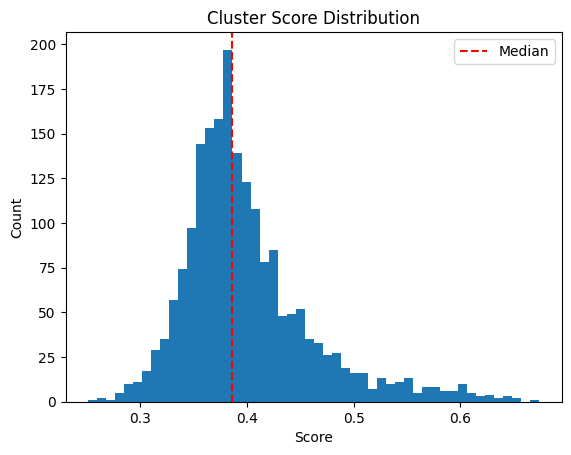

In [60]:
import matplotlib.pyplot as plt

plt.hist(cluster_scores.cpu().numpy(), bins=50)
plt.axvline(cluster_scores.median().item(), color='r', linestyle='--', label='Median')
plt.title("Cluster Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.legend()
plt.show()


In [53]:
from typing import Callable
def get_similarity_map(point_features:torch.Tensor, scale:float, scale_gate:Callable, clip_query_feature:torch.Tensor, q_trans:Callable[[torch.Tensor], torch.Tensor]):
    # scale = 0.5
    scale = torch.full((1,), scale).cuda()
    scale = q_trans(scale)

    gates = scale_gate(scale).detach().squeeze()

    print(point_features.shape, gates.shape)

    scale_conditioned_point_features = point_features * gates.unsqueeze(0)

    normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

    similarities = torch.einsum('C,NC->N', clip_query_feature, normed_scale_conditioned_point_features)

    return similarities


In [54]:
index = 0
similarities = get_similarity_map(feature_gaussians.get_point_features, corresponding_scales[index], scale_gate, clip_query_features[index], q_trans)
good_cluster_scores

torch.Size([1007732, 32]) torch.Size([32])


tensor([0.4505, 0.5118, 0.4604, 0.4766, 0.4654, 0.4689, 0.4551, 0.4504, 0.4601,
        0.5411, 0.4858, 0.4524, 0.4574, 0.4592, 0.4524, 0.5013, 0.5320, 0.4556,
        0.4704, 0.4629, 0.5285, 0.6086, 0.5194, 0.4506, 0.4744, 0.4652, 0.4650,
        0.5256, 0.4845, 0.4510, 0.4847, 0.5058, 0.4997, 0.4728, 0.4871, 0.4537,
        0.4604, 0.4695, 0.4956, 0.4511, 0.4546, 0.4500, 0.5326, 0.4548, 0.4598,
        0.4720, 0.4502, 0.5346, 0.5096, 0.4754, 0.4582, 0.5477, 0.4869, 0.6434,
        0.5615, 0.5666, 0.5268, 0.5517, 0.6445, 0.4642, 0.4575, 0.5283, 0.4568,
        0.4732, 0.4514, 0.4634, 0.5906, 0.4573, 0.4833, 0.5972, 0.6434, 0.4806,
        0.4725, 0.4529, 0.4869, 0.4797, 0.4579, 0.4672, 0.5480, 0.4681, 0.5349,
        0.4914, 0.5302, 0.4503, 0.5023, 0.4879, 0.4525, 0.4790, 0.4684, 0.4508,
        0.4637, 0.5258, 0.5638, 0.5127, 0.5474, 0.4533, 0.4543, 0.4642, 0.5490,
        0.4713, 0.4822, 0.4552, 0.4946, 0.5101, 0.4592, 0.5059, 0.4506, 0.6193,
        0.6499, 0.4513, 0.4503, 0.5310, 

In [55]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(similarities > 0.45)

print(similarity.max())

tensor(1.0000, device='cuda:0')


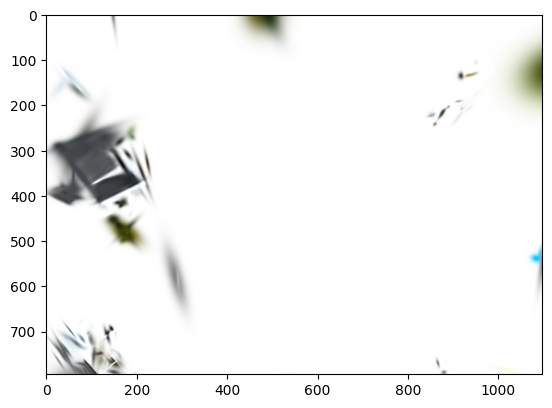

In [57]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[17], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())
